In [1]:
import sys
import warnings
import numpy as np
import pylab as plt
from numpy import pi
from copy import copy
from tqdm import tqdm
from time import time
from multiprocessing import Pool
from numpy.random import uniform
from imcn import calc_TE, calc_MI
from jitcsim.models.kuramoto_sde import Kuramoto_II
from imcn.utility import time_average_correlation_matrix_links
warnings.filterwarnings("ignore")

In [10]:
FIG_WIDTH, FIG_HEIGHT = 4, 4
plt.rc('figure', figsize=(FIG_WIDTH, FIG_HEIGHT))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

In [2]:
np.random.seed(2)

In [7]:
def simulateHalfLoop(parameters, direction, couplings, links, num_threads=1):

    if direction == "backward":
        couplings_ = copy(couplings[::-1])
    else:
        couplings_ = copy(couplings)

    n = len(couplings_)
    nl = len(links)
    R = np.zeros(n)
    Corr = np.zeros((n, nl))
    TE = np.zeros((n, nl))
    MI = np.zeros((n, nl))

    prev_phases = parameters['initial_state']

    # for itr in tqdm(range(n)):
    for itr in range(n):

        I = Kuramoto_II(parameters)
        I.set_initial_state(prev_phases)
        I.set_integrator_parameters(atol=1e-6, rtol=1e-3)
        data = I.simulate([couplings_[itr]], mode_2pi=False)
        x = data['x']
        # store the last phases as initial phases for next loop
        prev_phases = x[-1, :]

        # correlation matrix
        corr = time_average_correlation_matrix_links(x, links, step=10)

        # TE and MI
        te = np.zeros(nl)
        mi = np.zeros(nl)

        for i in range(nl):
            source_id = links[i][0]
            target_id = links[i][1]
            source = x[:-1, source_id]
            target = np.diff(x[:, target_id])
            if parameters["CALCUALTE_TE"]:
                te[i], _, _ = calc_TE(source,
                                target,
                                num_threads=num_threads)
            if parameters["CALCULATE_MI"]:
                mi[i], _, _ = calc_MI(source,
                                target,
                                TIME_DIFF=0,
                                NUM_THREADS=num_threads)
        
        TE[itr, :] = te
        MI[itr, :] = mi
        Corr[itr, :] = corr
        R[itr] = np.mean(I.order_parameter(x))

    return {"g": couplings_,
            "R": R,
            "te": TE,
            "mi": MI,
            "cor": Corr}
            

In [4]:
# SETTING PARAMETERS --------------------------------------------
N = 3
omega = [0.3, 0.4, 0.5]
initial_state = uniform(-pi, pi, N)
noise_amplitude = 0.005

# aij means there is a link from j to i
adj = np.asarray([[0, 1, 0],
                  [0, 0, 1],
                  [0, 0, 0]])

parameters = {
    'N': N,                             # number of nodes
    'adj': adj,                         # adjacency matrix
    't_initial': 0.,                    # initial time of integration
    "t_final": 500,                     # final time of integration
    't_transition': 400.0,              # transition time
    "interval": 0.05,                   # time interval for sampling

    "alpha": 0.0,                       # frustration
    "sigma": noise_amplitude,           # noise amplitude
    "omega": omega,                     # initial angular frequencies
    'initial_state': initial_state,     # initial phase of oscillators
    'control': ["coupling"],            # control parameters

    "use_omp": False,                   # use OpenMP
    "output": "data",                   # output directory
    "CALCUALTE_TE": True,
    "CALCULATE_MI": True
}

couplings = np.linspace(0.01, 0.3, 11)
num_ensembles = 3
# num_processes = 8
num_threads = 1
links = [(0, 1), (0, 2), (1, 2)]


In [5]:
# compilings ----------------------------------------------------
sol = Kuramoto_II(parameters)
sol.compile()

compiled C code


In [11]:
data_F = simulateHalfLoop(parameters, "forward", couplings, links, num_threads=num_threads)

In [13]:
data_B = simulateHalfLoop(parameters, "backward", couplings, links, num_threads=num_threads)

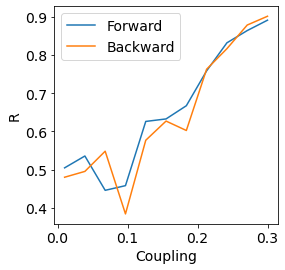

In [14]:
plt.plot(couplings, data_F["R"], label="Forward")
plt.plot(couplings[::-1], data_B["R"], label="Backward")
plt.xlabel("Coupling")
plt.ylabel("R")
plt.legend();